# Exploration of Seattle Building Permits Data

### Data Overview

This data come from the City of Seattle. Each record is represents a permit application for a building project. There are idenfication data fields such as the permit number, contractor or company associated with the permit, a link to the permit records; for some permits related to projects dependent on other building projects, there is also information aboout the parent permit. There is also datetime data related to each step in the process that has been recorded complete, from recieving a complete application, to several review steps, to issuance, expiration, and completion. There is location data including coordinates and address, which we will use to join to the Unreinforced Masonry Buildings data set if and where possible. Further, an estimated cost is included for many applications, along with information about the type of project or building the permit is for. A longer form description is of particular interest, since many projects indicate a detailed purpose related to seismic retrofitting. At the time of writing, the full data set has 185,867 entries, while 4,516 contain a phrase such as "seismic upgrade" or "earthquake retrofit". Of those, 4,205 have been recieved as complete applications.


### Questions Related to This Dataset

- How are the retrofit applications distributed over time and geographically throughout Seattle? Is the pace increasing? Is the spread correlated to the spread of the most at risk buildings, ECA slide areas, and ECA liquefaction prone areas?
- How does the number of seismic upgrade project applications and average estimated cost vary by neighborhood?
- Does the time from application to issuance and completion vary by neighborhood and permit class?
- What proportion of Unreinforced Masonry Buildings can be linked to pending permits? Does this differ by neighborhood?
- How does the estimated cost vary by neighborhood and permit class?

In [20]:
from requests import get as get_request
from io import BytesIO
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import altair as alt

In [5]:

filename = 'Building_Permits_20251125.csv'
permits = pd.read_csv(os.path.join(os.getcwd(), 'data', filename))

C:\Users\ellin\AppData\Local\Temp\ipykernel_27480\2644830692.py:2: DtypeWarning: Columns (25,26,27,28,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  permits = pd.read_csv(os.path.join(os.getcwd(), 'data', filename))


In [6]:
print(permits.shape)
print(permits.isna().sum(axis=0))

(185867, 40)
PermitNum                         0
PermitClass                    6820
PermitClassMapped              6820
PermitTypeMapped                  0
PermitTypeDesc                12264
Description                     674
HousingUnits                      0
HousingUnitsRemoved           97586
HousingUnitsAdded             97586
EstProjectCost                35112
AppliedDate                   43895
IssuedDate                    50778
ExpiresDate                   50644
CompletedDate                 82893
StatusCurrent                     0
RelatedMup                   171608
OriginalAddress1                856
OriginalCity                   8290
OriginalState                  8161
OriginalZip                    9361
ContractorCompanyName        156105
Link                              0
Latitude                       1005
Longitude                      1005
Location1                      1005
TotalDaysPlanReview          156452
DaysInitialPlanReview        156047
DaysPlanReviewC

In [7]:
permits.head()

,PermitNum,PermitClass,PermitClassMapped,PermitTypeMapped,PermitTypeDesc,Description,HousingUnits,HousingUnitsRemoved,HousingUnitsAdded,EstProjectCost,...,InitialReviewCompleteDate,PlanReviewCompleteDate,DaysIssuePermitCity,ReadyToIssueDate,Zoning,DwellingUnitType,StandardPlan,DependentBuilding,ParentPermitNum,HousingCategory
0,3001776-EX,Commercial,Non-Residential,ECA and Shoreline Exemption/Street Improvement...,Environmentally Critical Area Exemption,Exception/Exemption Request for: Land Use Appl...,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,3002256-EX,Single Family/Duplex,Residential,ECA and Shoreline Exemption/Street Improvement...,Environmentally Critical Area Exemption,Exception/Exemption Request for: CANCELLED 3/8...,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3002287-EX,Single Family/Duplex,Residential,ECA and Shoreline Exemption/Street Improvement...,Environmentally Critical Area Exemption,Exception/Exemption Request for: Land Use Appl...,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
3,3003446-EX,Industrial,Non-Residential,ECA and Shoreline Exemption/Street Improvement...,Shoreline Exemption,Exception/Exemption Request for: CANCELLED 3/2...,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
4,3003449-EX,Multifamily,Residential,ECA and Shoreline Exemption/Street Improvement...,Environmentally Critical Area Exemption,Exception/Exemption Request for: CANCELED PER ...,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN


In [9]:
permits.Description

0         Exception/Exemption Request for: Land Use Appl...
1         Exception/Exemption Request for: CANCELLED 3/8...
2         Exception/Exemption Request for: Land Use Appl...
3         Exception/Exemption Request for: CANCELLED 3/2...
4         Exception/Exemption Request for: CANCELED PER ...
                                ...                        
185862    Construct engineered voluntary seismic retrofi...
185863    Central OMF Site Improvements and site modific...
185864    Construct east one-family dwelling  per plan. ...
185865    Construct non-structural repairs to condominiu...
185866    Construct commercial floating building (Boat S...
Name: Description, Length: 185867, dtype: object

### Filter for Earthquake Repair and Seismic Retrofit permits

In [12]:
RETROFIT_PHRASES = [
    'seismic retrofit',
    'seismic upgrade',
    'seismic proof',
    'seismic home retrofit',
    'seismic home upgrade',
    'seismic home proof',
    'seismically retrofit',
    'seismically upgrade',
    'seismically proof',
    'earthquake retrofit',
    'earthquake upgrade',
    'earthquake proof',
    'earthquake home retrofit',
    'earthquake home upgrade',
    'earthquake home proof'
]

def check_for_retrofits(description, check_phrases = RETROFIT_PHRASES):
    '''
    Checks description for mentions of seismic retrofits and earthquake retrofits
    '''
    if pd.isna(description):
        return False
    normalized_description = ' '.join(description.split()).lower()
    return any([phrase in normalized_description for phrase in check_phrases])
    

retrofits = permits[permits['Description'].apply(func=check_for_retrofits)]
retrofits.shape

(4516, 40)

In [13]:
retrofits.head()

,PermitNum,PermitClass,PermitClassMapped,PermitTypeMapped,PermitTypeDesc,Description,HousingUnits,HousingUnitsRemoved,HousingUnitsAdded,EstProjectCost,...,InitialReviewCompleteDate,PlanReviewCompleteDate,DaysIssuePermitCity,ReadyToIssueDate,Zoning,DwellingUnitType,StandardPlan,DependentBuilding,ParentPermitNum,HousingCategory
678,6062875-CN,Single Family/Duplex,Residential,Building,Addition/Alteration,Volutary seismic upgrade to existing single-fa...,0,0.0,0.0,"4,300",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Single-Family Add/Alt
859,6063832-CN,Commercial,Non-Residential,Building,Addition/Alteration,Voluntary Seismic Retrofit at roof level only ...,0,0.0,0.0,"208,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Commercial Add/Alt
1040,6064791-CN,Single Family/Duplex,Residential,Building,Addition/Alteration,Closed as Incomplete - Expired Permit REMOV...,0,NaN,NaN,"17,760",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Single-Family Add/Alt
1090,6065241-CN,Single Family/Duplex,Residential,Building,Addition/Alteration,Construct dormer addition per plan and seismic...,0,0.0,0.0,"50,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Single-Family Add/Alt
1214,6066366-CN,Single Family/Duplex,Residential,Building,Addition/Alteration,seismic retrofit for project impact,0,0.0,0.0,"3,000",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Single-Family Add/Alt


In [19]:
unique_values = retrofits.apply(lambda s: s.unique().shape[0])
unique_values

PermitNum                    4516
PermitClass                     7
PermitClassMapped               3
PermitTypeMapped                4
PermitTypeDesc                  8
Description                  2866
HousingUnits                    9
HousingUnitsRemoved             5
HousingUnitsAdded               8
EstProjectCost                886
AppliedDate                  2457
IssuedDate                   2452
ExpiresDate                  2444
CompletedDate                2498
StatusCurrent                  16
RelatedMup                     17
OriginalAddress1             4223
OriginalCity                    3
OriginalState                   2
OriginalZip                    29
ContractorCompanyName         210
Link                         4516
Latitude                     4202
Longitude                    4208
Location1                    4208
TotalDaysPlanReview           169
DaysInitialPlanReview         105
DaysPlanReviewCity            138
DaysOutCorrections            115
NumberReviewCy

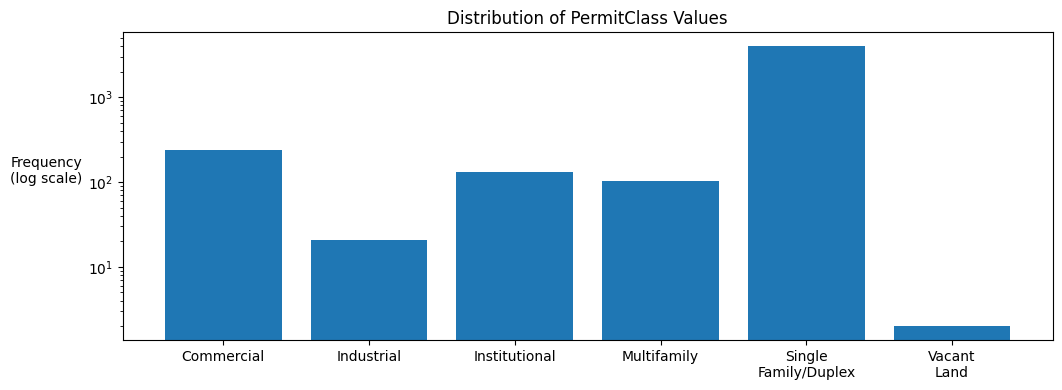

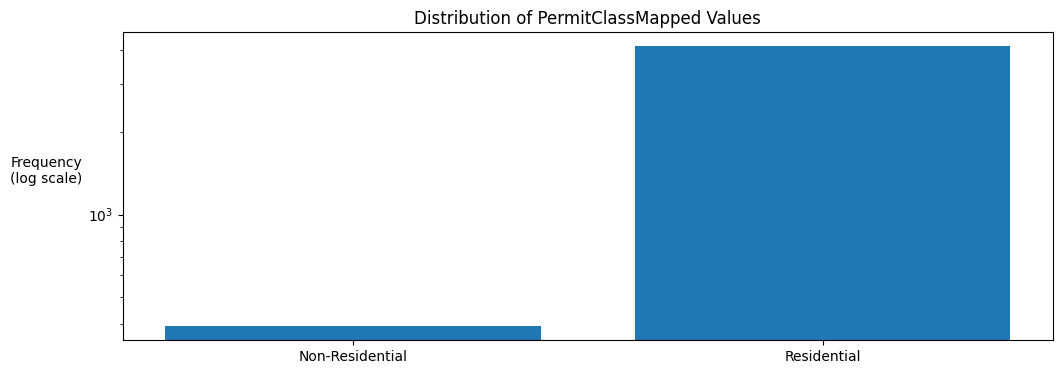

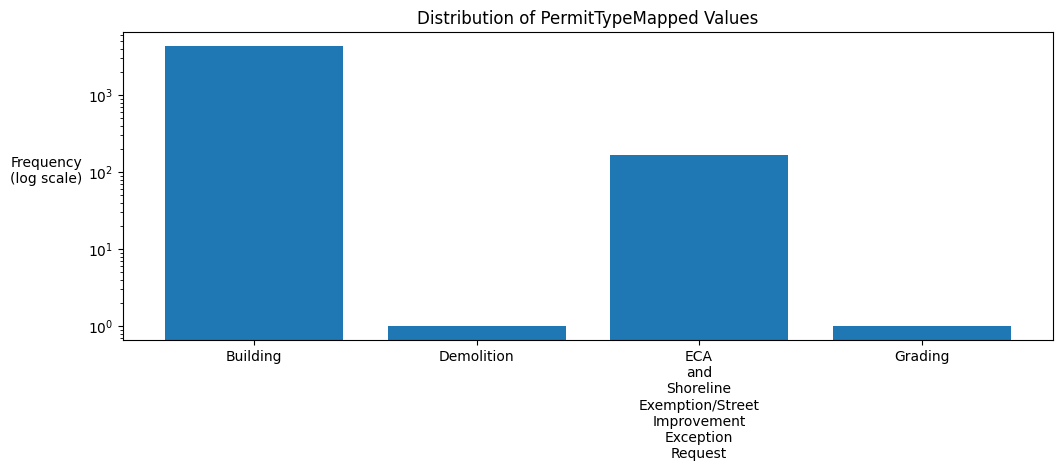

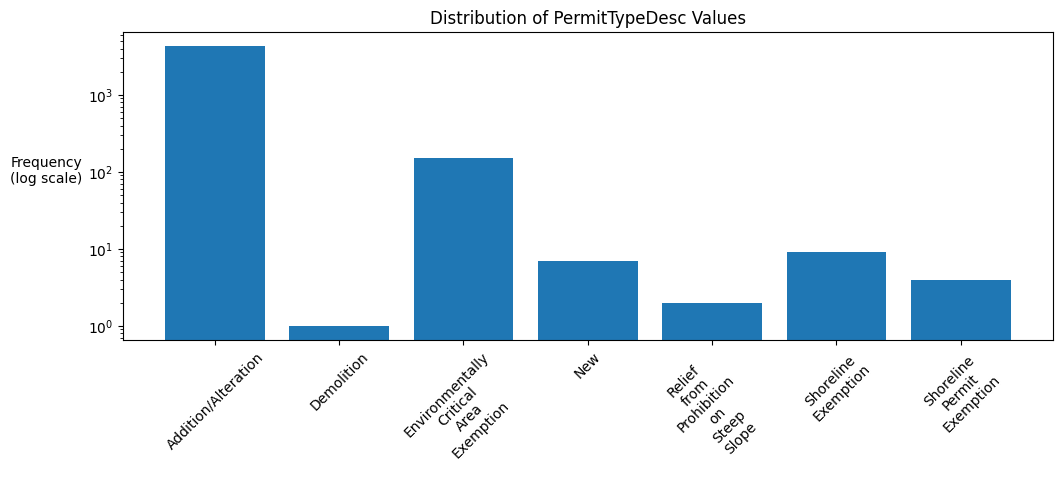

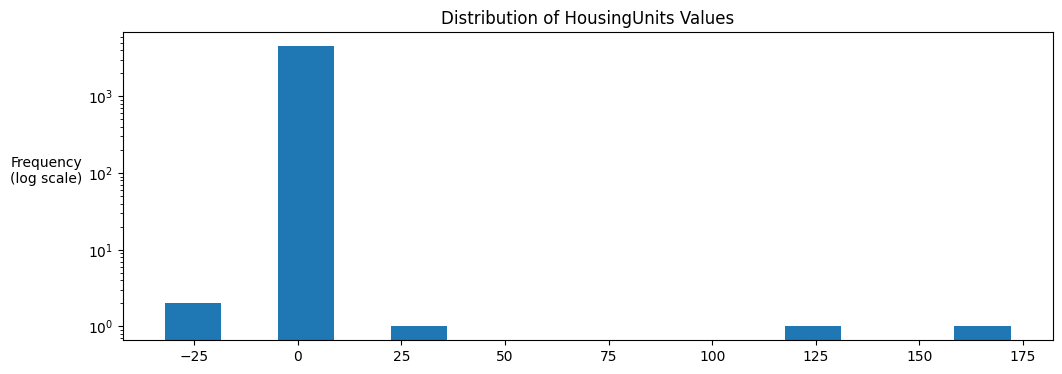

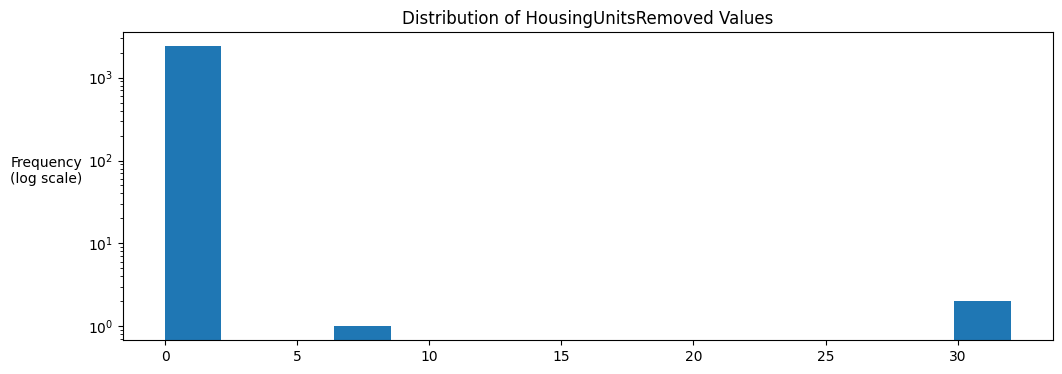

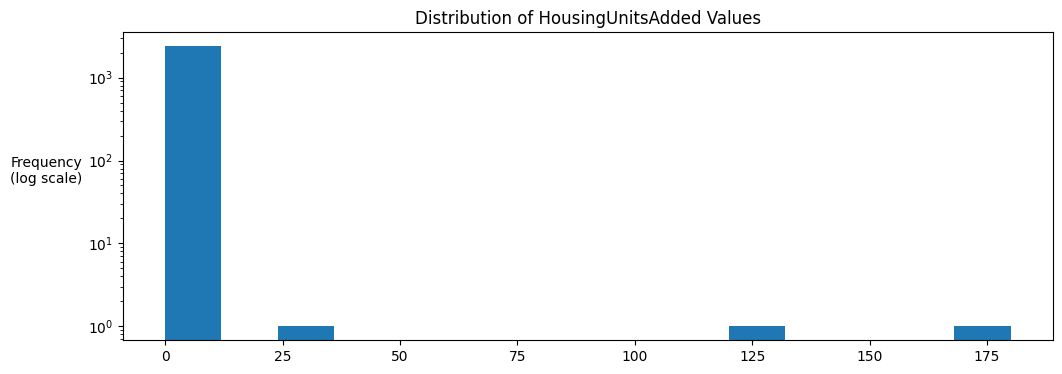

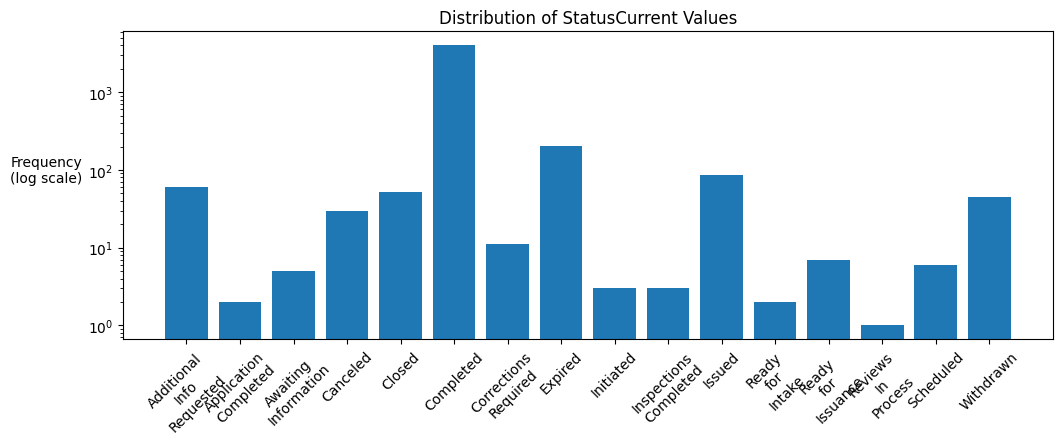

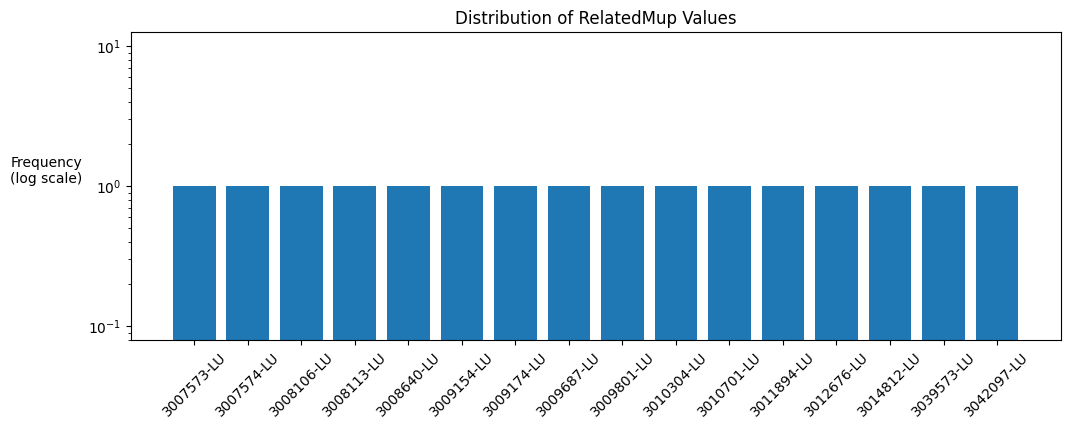

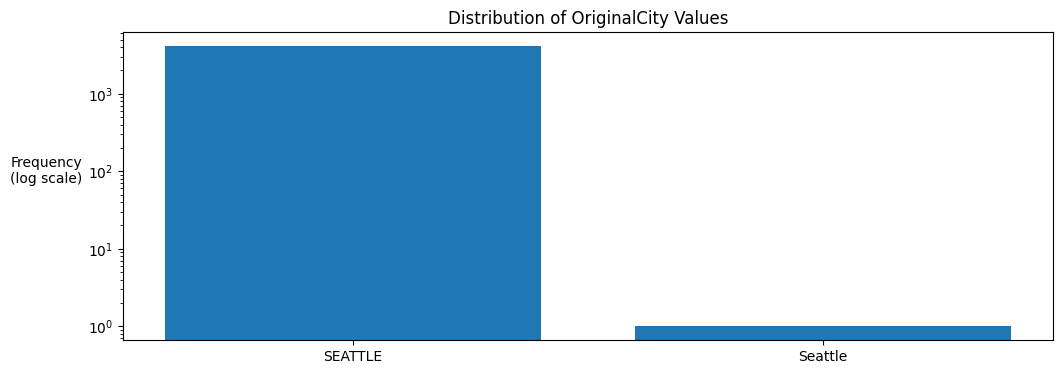

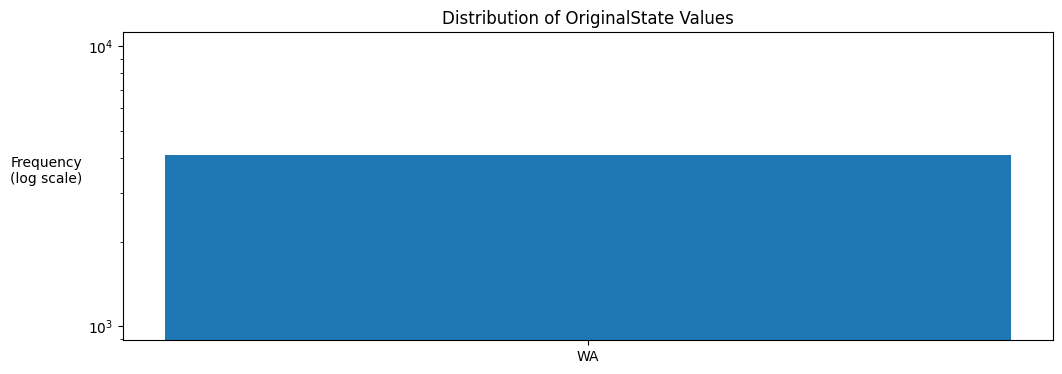

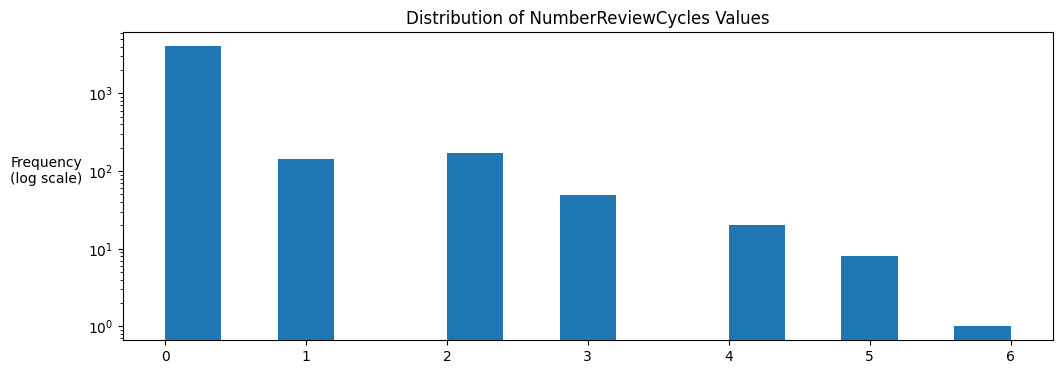

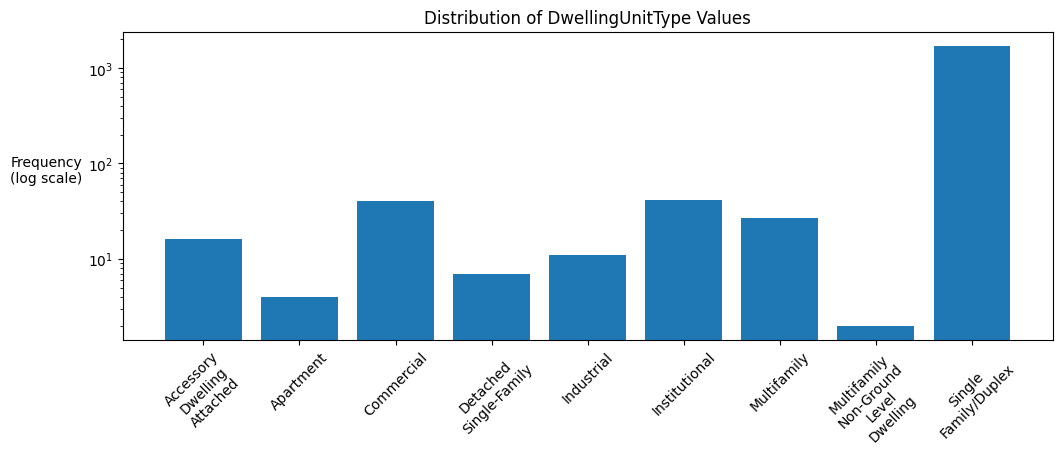

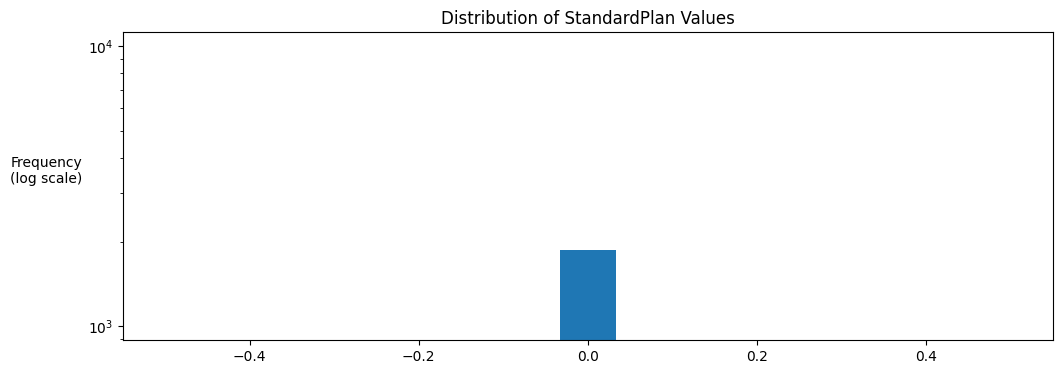

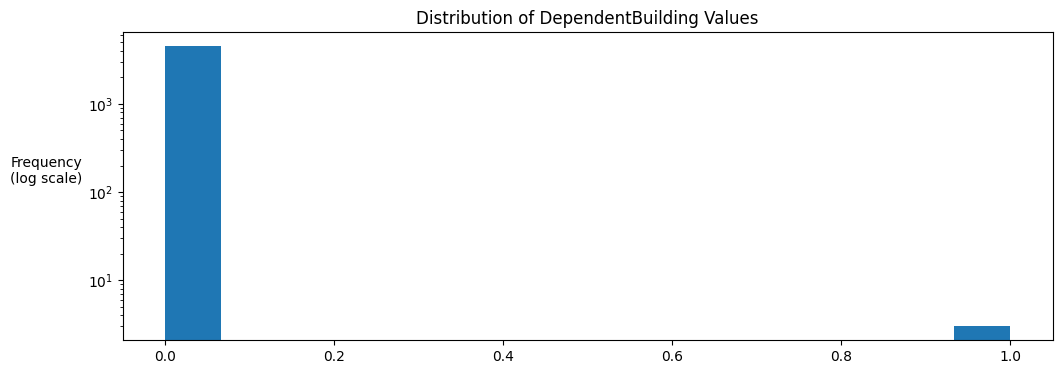

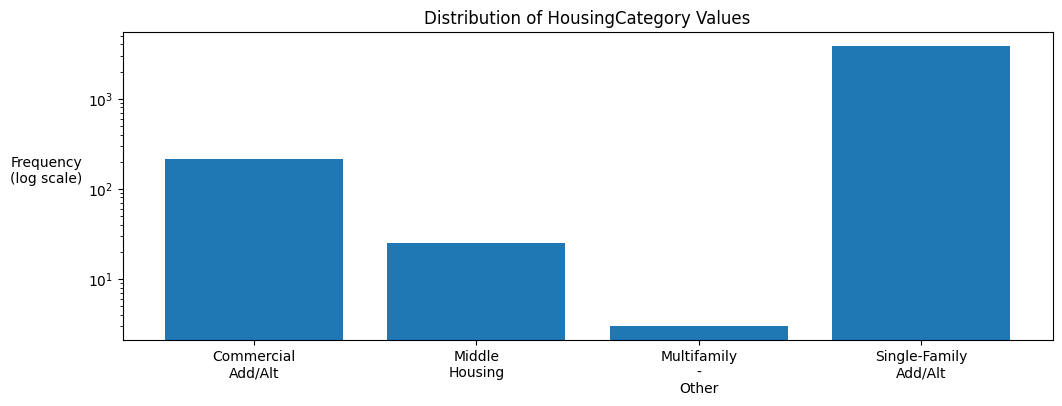

In [ ]:
few_value_cols = unique_values[unique_values <= 20].index.to_list()

for col in few_value_cols:
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot()
    value_cnts = retrofits[col].value_counts().sort_index()
    if pd.api.types.is_numeric_dtype(retrofits[col]):
        ax.hist(retrofits[col], bins=15)
    else:
        ax.bar(value_cnts.index, value_cnts.values)
    ax.set_title(f'Distribution of {col} Values')
    ax.set_ylabel('Frequency\n(log scale)', rotation=0, labelpad=30)
    ax.set_yscale('log')
    if pd.api.types.is_string_dtype(value_cnts.index) or pd.api.types.is_object_dtype(value_cnts.index):
        ax.set_xticks([t for t in range(value_cnts.shape[0])])
        ax.set_xticklabels([label.replace(" ", "\n") for label in value_cnts.index.tolist()])
        rotate = 45
        if len(value_cnts) < 7:
            rotate = 0
        ax.tick_params(axis='x', labelrotation=rotate)
    plt.tight_layout()
    plt.show()

In [ ]:
# clean up different names for seattle ('SEATTLE' and 'seattle')
retrofits['OriginalCity'] = retrofits['OriginalCity'].str.lower()

In [52]:
# how many applications have been issued and completed versus recieved?, does this differ by area of the city?
# NA AppliedDate implies application is still incomplete and has not been accepted for review. CompletedDate should be on or before ExpiresDate, and 

# date cols ordered by process step start to finish
date_cols = ['AppliedDate', 'InitialReviewCompleteDate', 'PlanReviewCompleteDate', 'ReadyToIssueDate', 'IssuedDate', 'ExpiresDate', 'CompletedDate']
print('---  NA counts  ---')
print(retrofits[date_cols].isna().sum(axis=0))

---  NA counts  ---
AppliedDate                   311
InitialReviewCompleteDate    4130
PlanReviewCompleteDate       4133
ReadyToIssueDate             2627
IssuedDate                    377
ExpiresDate                   376
CompletedDate                 776
dtype: int64


In [55]:
# drop incomplete applications for now
retrofits = retrofits.dropna(subset='AppliedDate')
retrofits.shape

(4205, 40)

In [ ]:
retrofits['AppliedDate'] = pd.to_datetime(retrofits.AppliedDate)

dtype('<M8[ns]')

In [ ]:
# look at permit distribution over time and spatially

# seattle basemap


# permit points


# AppliedDate histogram brush


# create interactive visual

### References

1. City of Seattle, Department of Construction & Inspections. (2017). *Building Permits* [Data set]. City of Seattle Open Data Portal.  
https://data.seattle.gov/Built-Environment/Building-Permits/76t5-zqzr  
(Last updated November 25, 2025; License: Public Domain)

